In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [65]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
702124               2020-09-11           2020-09-09            2020-09-09   
702125               2020-09-11           2020-09-09            2020-09-09   
702126               2020-09-11           2020-09-08            2020-09-08   
702127               2020-09-11           2020-09-08            2020-09-08   
702128               2020-09-11           2020-09-10            2020-09-10   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
702124                             NaT                   NaT   
702125                             NaT                   NaT   
702126                             NaT                   NaT   
702127                             NaT                   NaT   
702128                             NaT                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento  \
Id de caso                                                            
1                         NaT          Bogotá d.c.      Bogotá D.C.   
2                         NaT  Guadalajara de buga  Valle del Cauca   
3                         NaT             Medellín        Antioquia   
4                         NaT             Medellín        Antioquia   
5                         NaT             Medellín        Antioquia   
...                       ...                  ...              ...   
702124                    NaT          Bogotá d.c.      Bogotá D.C.   
702125                    NaT          Bogotá d.c.      Bogotá D.C.   
702126                    NaT          Bogotá d.c.      Bogotá D.C.   
702127                    NaT          Bogotá d.c.      Bogotá D.C.   
702128                    NaT          Bogotá d.c.      Bogotá D.C.   

               Severidad      Estado  ...  Clasificación de edad Sexo  \
Id de caso                            ...                               
1                   Leve  Recuperado  ...                10 - 20    F   
2                   Leve  Recuperado  ...                30 - 40    M   
3                   Leve  Recuperado  ...                40 - 50    F   
4                   Leve  Recuperado  ...                50 - 60    M   
5                   Leve  Recuperado  ...                20 - 30    M   
...                  ...         ...  ...                    ...  ...   
702124      Asintomático        Casa  ...                50 - 60    M   
702125      Asintomático        Casa  ...                20 - 30    F   
702126      Asintomático        Casa  ...                30 - 40    M   
702127      Asintomático        Casa  ...                20 - 30    F   
702128      Asintomático        Casa  ...                50 - 60    F   

           Pertenecia Étnica Nombre Grupo Étnico         Tipo  \
Id de caso                                                      
1                       Otro                 NaN    Importado   
2                      Negro                 NaN    Importado   
3                       Otro 

### - Casos activos VS Departamento (Estado)

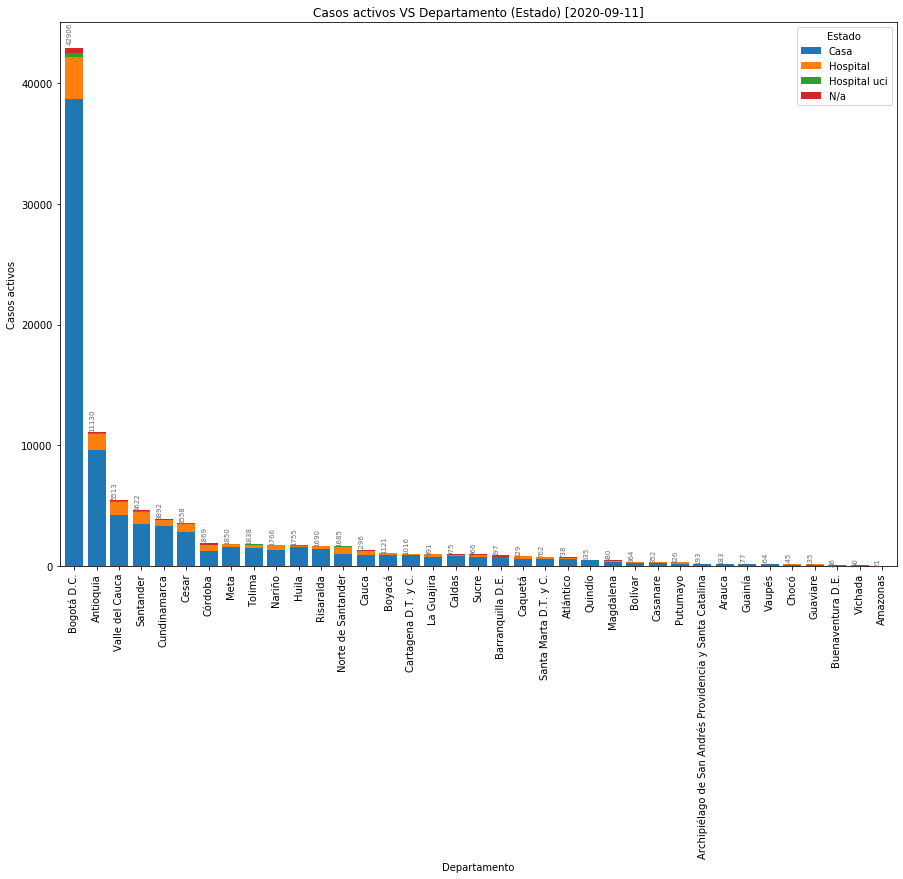

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         38667.0    3542.0   
Antioquia                                            9614.0    1296.0   
Valle del Cauca                                      4191.0    1138.0   
Santander                                            3496.0    1021.0   
Cundinamarca                                         3317.0     498.0   
Cesar                                                2861.0     638.0   
Córdoba                                              1227.0     521.0   
Meta                                                 1598.0     227.0   
Tolima                                               1490.0     292.0   
Nariño                                               1351.0     361.0   
Huila                                                1583.0     100.0   
Risaralda                                            1435.0     225.0   
Norte de Santander                                    986.0     571.0   
Cauca                                                 917.0     340.0   
Boyacá                                                950.0     145.0   
Cartagena D.T. y C.                                   926.0      52.0   
La Guajira                                            790.0     178.0   
Caldas                                                850.0     104.0   
Sucre                                                 760.0     172.0   
Barranquilla D.E.                                     765.0      19.0   
Caquetá                                               561.0     243.0   
Santa Marta D.T. y C.                                 558.0     177.0   
Atlántico                                             550.0      87.0   
Quindío                                               481.0      52.0   
Magdalena                                             301.0     137.0   
Bolívar                                               257.0      69.0   
Casanare                                              276.0      70.0   
Putumayo                                              178.0     142.0   
Archipiélago de San Andrés Providencia y Santa ...    174.0      18.0   
Arauca                                                161.0      20.0   
Guainía                                               170.0       7.0   
Vaupés                                                152.0      10.0   
Chocó                                                  85.0      46.0   
Guaviare                                              121.0      12.0   
Buenaventura D.E.                                      61.0      19.0   
Vichada                                                46.0       3.0   
Amazonas                                               11.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                308.0  389.0   
Antioquia                                                   84.0  136.0   
Valle del Cauca                                             54.0  130.0   
Santander                                                   66.0   39.0   
Cundinamarca                                                36.0   41.0   
Cesar                                                       34.0   25.0   
Córdoba                                                     16.0  105.0   
Meta                                                         7.0   18.0   
Tolima                                                      20.0   36.0   
Nariño                                                      17.0   37.0   
Huila                                                       56.0   16.0   
Risaralda                                                   17.0   13.0   
Norte de Santander                                         105.0   23.0   
Cauca                      

### - Recuperados y Fallecidos VS Departamento

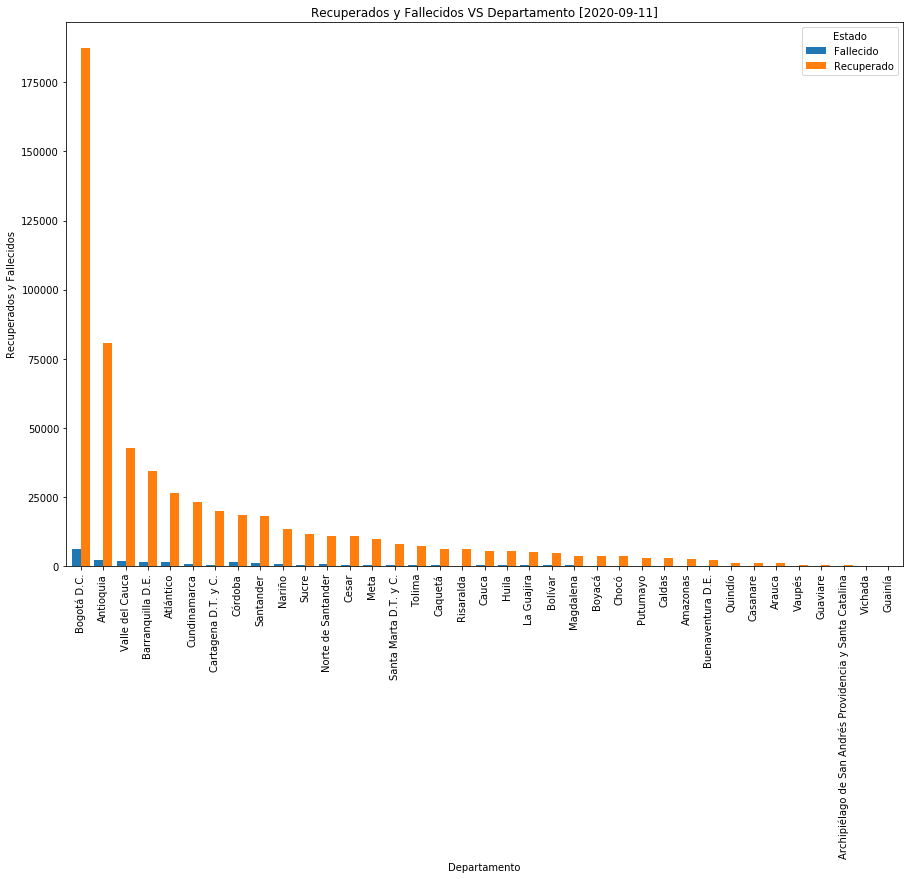

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [16]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6086.0    187321.0
Antioquia                                              2034.0     80563.0
Valle del Cauca                                        1816.0     42744.0
Barranquilla D.E.                                      1640.0     34446.0
Atlántico                                              1330.0     26580.0
Cundinamarca                                            806.0     23077.0
Cartagena D.T. y C.                                     532.0     19997.0
Córdoba                                                1439.0     18584.0
Santander                                              1023.0     18124.0
Nariño                                                  599.0     13506.0
Sucre                                                   540.0     11479.0
Norte de Santander                                      780.0     10964.0
Cesar                                                   412.0     11013.0
Meta                                                    308.0      9940.0
Santa Marta D.T. y C.                                   395.0      8053.0
Tolima                                                  233.0      7262.0
Caquetá                                                 249.0      6161.0
Risaralda                                               168.0      6204.0
Cauca                                                   203.0      5513.0
Huila                                                   220.0      5411.0
La Guajira                                              257.0      5190.0
Bolívar                                                 203.0      4674.0
Magdalena                                               358.0      3559.0
Boyacá                                                  100.0      3813.0
Chocó                                                   146.0      3562.0
Putumayo                                                145.0      2863.0
Caldas                                                   83.0      2747.0
Amazonas                                                113.0      2587.0
Buenaventura D.E.                                       162.0      2238.0
Quindío                                                  56.0      1272.0
Casanare                                                 31.0      1049.0
Arauca                                                   26.0       987.0
Vaupés                                                    2.0       353.0
Guaviare                                                  4.0       303.0
Archipiélago de San Andrés Providencia y Santa ...        6.0       232.0
Vichada                                                   4.0       169.0
Guainía                                                   9.0       154.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

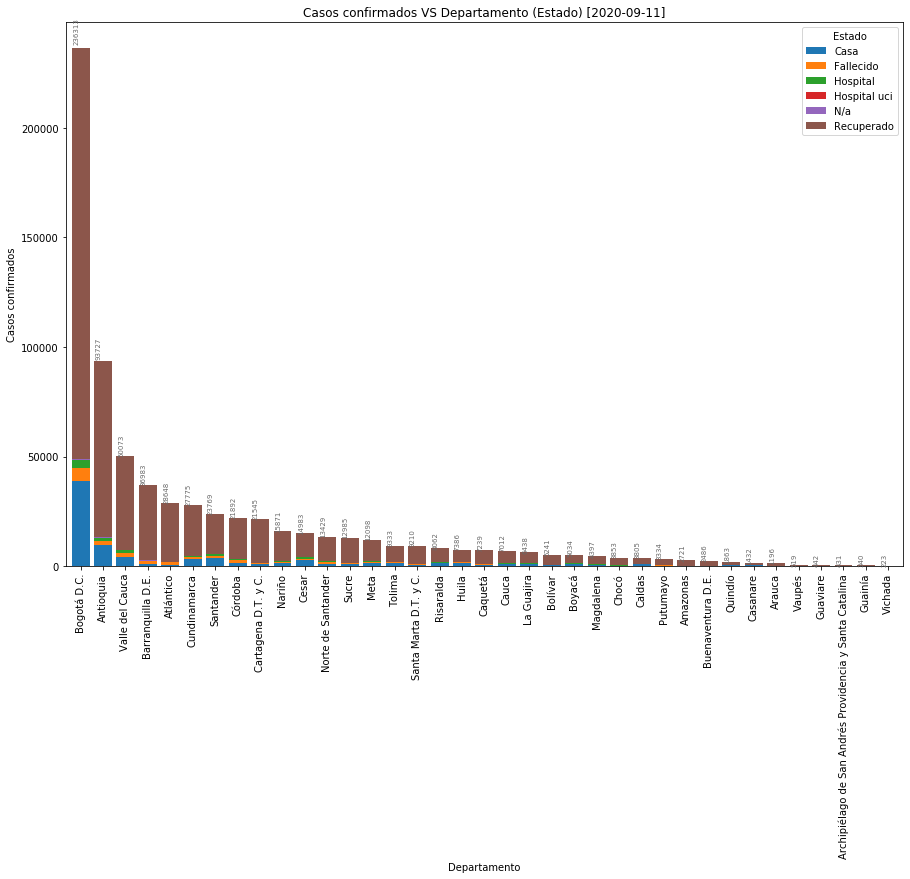

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         38667.0     6086.0   
Antioquia                                            9614.0     2034.0   
Valle del Cauca                                      4191.0     1816.0   
Barranquilla D.E.                                     765.0     1640.0   
Atlántico                                             550.0     1330.0   
Cundinamarca                                         3317.0      806.0   
Santander                                            3496.0     1023.0   
Córdoba                                              1227.0     1439.0   
Cartagena D.T. y C.                                   926.0      532.0   
Nariño                                               1351.0      599.0   
Cesar                                                2861.0      412.0   
Norte de Santander                                    986.0      780.0   
Sucre                                                 760.0      540.0   
Meta                                                 1598.0      308.0   
Tolima                                               1490.0      233.0   
Santa Marta D.T. y C.                                 558.0      395.0   
Risaralda                                            1435.0      168.0   
Huila                                                1583.0      220.0   
Caquetá                                               561.0      249.0   
Cauca                                                 917.0      203.0   
La Guajira                                            790.0      257.0   
Bolívar                                               257.0      203.0   
Boyacá                                                950.0      100.0   
Magdalena                                             301.0      358.0   
Chocó                                                  85.0      146.0   
Caldas                                                850.0       83.0   
Putumayo                                              178.0      145.0   
Amazonas                                               11.0      113.0   
Buenaventura D.E.                                      61.0      162.0   
Quindío                                               481.0       56.0   
Casanare                                              276.0       31.0   
Arauca                                                161.0       26.0   
Vaupés                                                152.0        2.0   
Guaviare                                              121.0        4.0   
Archipiélago de San Andrés Providencia y Santa ...    174.0        6.0   
Guainía                                               170.0        9.0   
Vichada                                                46.0        4.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3542.0         308.0   
Antioquia                                             1296.0          84.0   
Valle del Cauca                                       1138.0          54.0   
Barranquilla D.E.                                       19.0           1.0   
Atlántico                                               87.0           7.0   
Cundinamarca                                           498.0          36.0   
Santander                                             1021.0          66.0   
Córdoba                                                521.0          16.0   
Cartagena D.T. y C.                                     52.0           1.0   
Nariño                                                 361.0          17.0   
Cesar                                                  638.0          34.0   
Norte de Santander                                     571.0         105.0   
Sucre                

### - Casos confirmados VS Departamento (Sexo)

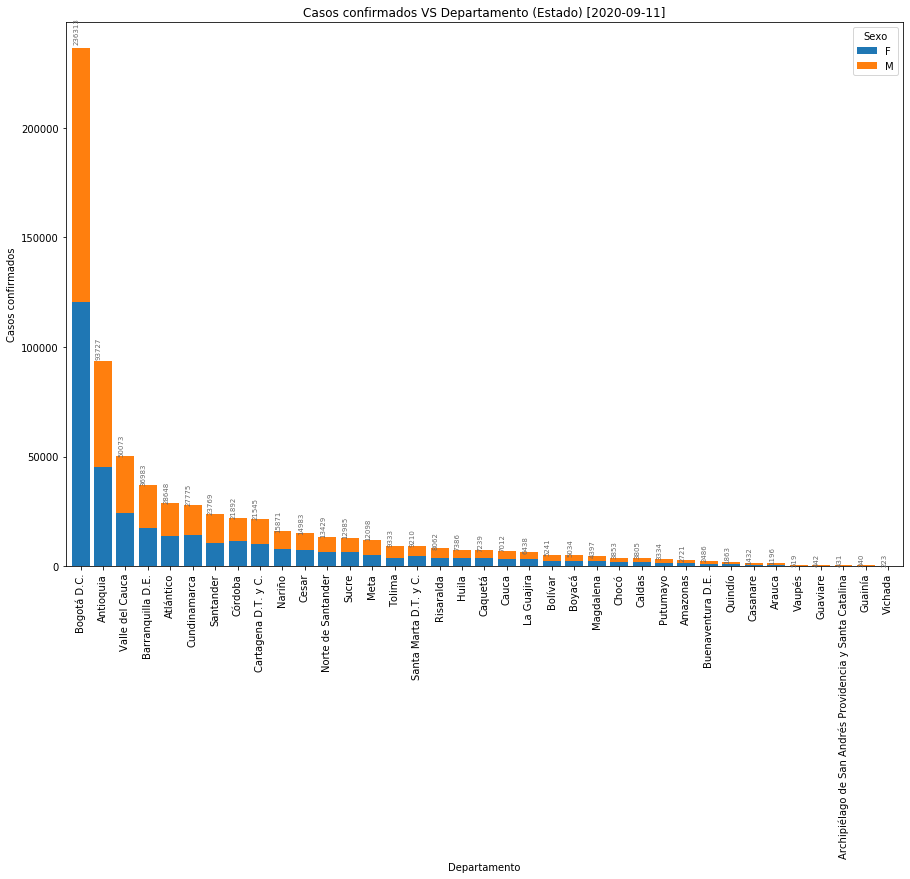

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         120599  115714  236313
Antioquia                                            45327   48400   93727
Valle del Cauca                                      24412   25661   50073
Barranquilla D.E.                                    17492   19491   36983
Atlántico                                            13578   15070   28648
Cundinamarca                                         14126   13649   27775
Santander                                            10663   13106   23769
Córdoba                                              11334   10558   21892
Cartagena D.T. y C.                                  10022   11523   21545
Nariño                                                7688    8183   15871
Cesar                                                 7312    7671   14983
Norte de Santander                                    6259    7170   13429
Sucre                                                 6395    6590   12985
Meta                                                  4819    7279   12098
Tolima                                                3678    5655    9333
Santa Marta D.T. y C.                                 4641    4569    9210
Risaralda                                             3864    4198    8062
Huila                                                 3602    3784    7386
Caquetá                                               3578    3661    7239
Cauca                                                 3417    3595    7012
La Guajira                                            3312    3126    6438
Bolívar                                               2474    2767    5241
Boyacá                                                2378    2656    5034
Magdalena                                             2227    2170    4397
Chocó                                                 1830    2023    3853
Caldas                                                1800    2005    3805
Putumayo                                              1560    1774    3334
Amazonas                                              1174    1547    2721
Buenaventura D.E.                                      917    1569    2486
Quindío                                                937     926    1863
Casanare                                               611     821    1432
Arauca                                                 424     772    1196
Vaupés                                                 233     286     519
Guaviare                                               140     302     442
Archipiélago de San Andrés Providencia y Santa ...     215     216     431
Guainía                                                154     186     340
Vichada                                                 76     147     223

### - Mapa de influencia COVID-19 (Colombia)

In [21]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

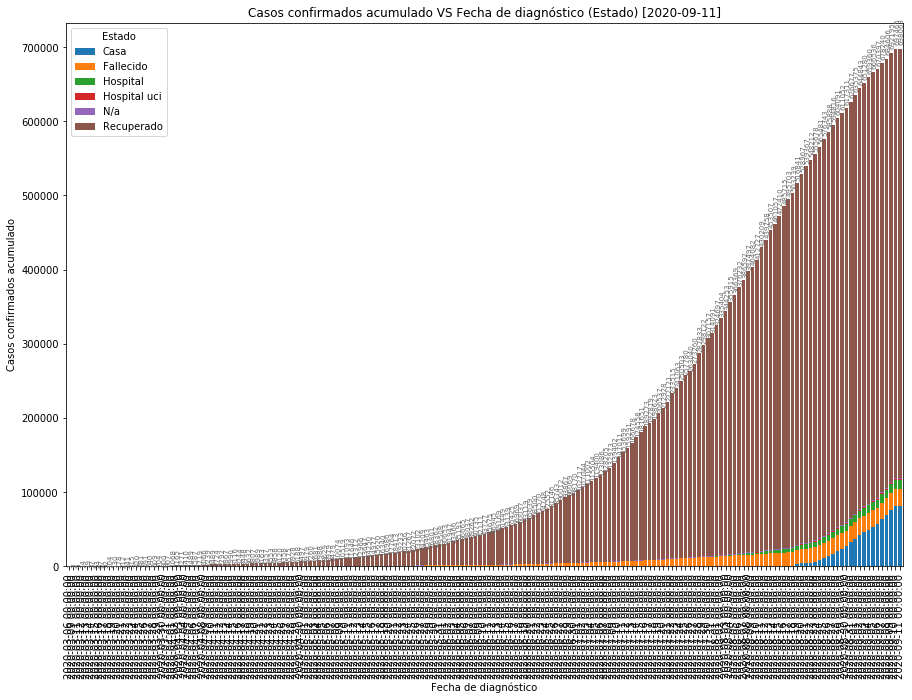

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-09-11            81859.0    22309.0   12552.0         921.0  1452.0   
2020-09-10            81295.0    22309.0   12518.0         921.0  1452.0   
2020-09-09            76388.0    22309.0   12196.0         905.0  1452.0   
2020-09-08            69458.0    22246.0   11788.0         897.0  1450.0   
2020-09-07            63822.0    22188.0   11477.0         887.0  1449.0   
2020-09-06            56701.0    22116.0   11155.0         868.0  1443.0   
2020-09-05            53564.0    22073.0   10980.0         862.0  1442.0   
2020-09-04            49497.0    21994.0   10541.0         848.0  1440.0   
2020-09-03            46438.0    21908.0   10326.0         819.0  1432.0   
2020-09-02            42764.0    21819.0   10073.0         811.0  1427.0   
2020-09-01            37447.0    21614.0    9842.0         790.0  1416.0   
2020-08-31            32394.0    21479.0    9607.0         774.0  1412.0   
2020-08-30            26927.0    21308.0    9268.0         747.0  1405.0   
2020-08-29            23819.0    21206.0    9019.0         713.0  1394.0   
2020-08-28            20838.0    21065.0    8760.0         685.0  1388.0   
2020-08-27            17160.0    20865.0    8335.0         639.0  1383.0   
2020-08-26            14030.0    20650.0    7997.0         612.0  1372.0   
2020-08-25            11408.0    20379.0    7644.0         578.0  1360.0   
2020-08-24             8423.0    20146.0    7304.0         545.0  1347.0   
2020-08-23             6457.0    19867.0    6969.0         507.0  1330.0   
2020-08-22             4776.0    19701.0    6717.0         494.0  1324.0   
2020-08-21             4219.0    19445.0    6339.0         488.0  1312.0   
2020-08-20             4040.0    19169.0    5939.0         461.0  1292.0   
2020-08-19             3012.0    18747.0    5424.0         422.0  1276.0   
2020-08-18              941.0    18415.0    4986.0         378.0  1257.0   
2020-08-17              589.0    18153.0    4722.0         370.0  1233.0   
2020-08-16              528.0    17951.0    4478.0         349.0  1220.0   
2020-08-15              474.0    17638.0    4129.0         322.0  1208.0   
2020-08-14              373.0    17332.0    3781.0         302.0  1198.0   
2020-08-13              278.0    17081.0    3567.0         290.0  1187.0   
2020-08-12              240.0    16749.0    3195.0         269.0  1167.0   
2020-08-11              144.0    16373.0    2862.0         247.0  1154.0   
2020-08-10              110.0    15948.0    2350.0         210.0  1130.0   
2020-08-09               57.0    15713.0    2085.0         190.0  1110.0   
2020-08-08               28.0    15480.0    1860.0         178.0  1103.0   
2020-08-07               28.0    15141.0    1626.0         154.0  1083.0   
2020-08-06               23.0    14841.0    1368.0         114.0  1062.0   
2020-08-05               20.0    14546.0    1144.0          83.0  1039.0   
2020-08-04               20.0    14246.0     865.0          54.0  1014.0   
2020-08-03               19.0    13907.0     593.0          24.0   995.0   
2020-08-02               18.0    13558.0     342.0          14.0   973.0   
2020-08-01               18.0    13182.0     286.0           8.0   957.0   
2020-07-31               10.0    12829.0     253.0           7.0   934.0   
2020-07-30               10.0    12583.0     220.0           7.0   917.0   
2020-07-29               10.0    12284.0     199.0           7.0   896.0   
2020-07-28                9.0    11980.0     179.0           7.0   872.0   
2020-07-27                9.0    11415.0     163.0           7.0   827.0   
2020-07-26                8.0    11080.0     137.0           6.0   802.0   
2020-07-25                8.0    10829.0     130.0           6.0   788.0   
2020-07-24                8.0    10519.0     116.0           5.0   769.0   
2020-07-23                8.0    10209.0      93

### - Casos confirmados VS Fecha de diagnóstico (Estado)

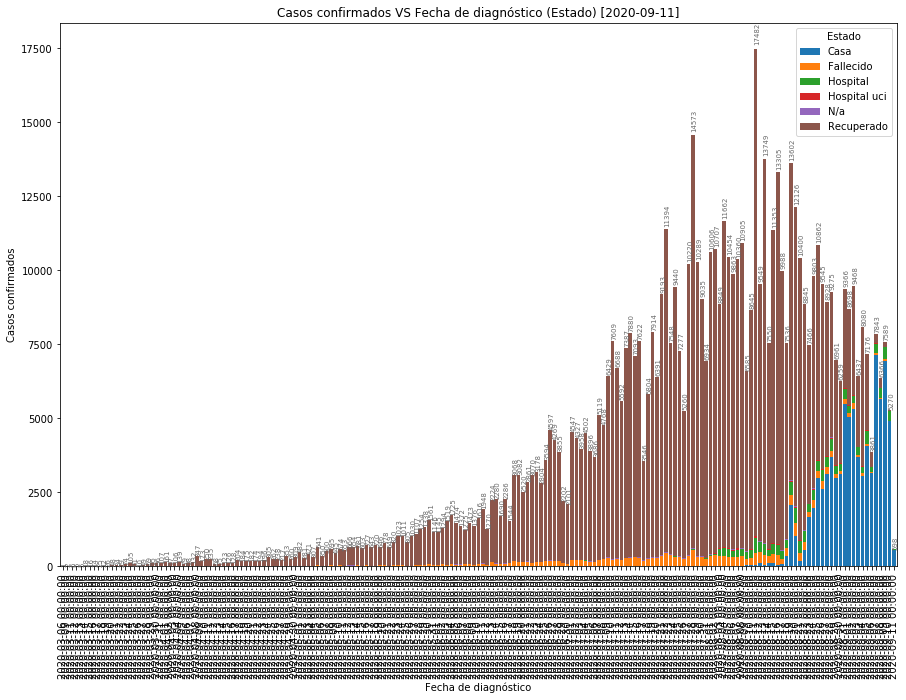

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-11             564.0        0.0      34.0           0.0   0.0   
2020-09-10            4907.0        0.0     322.0          16.0   0.0   
2020-09-09            6930.0       63.0     408.0           8.0   2.0   
2020-09-08            5636.0       58.0     311.0          10.0   1.0   
2020-09-07            7121.0       72.0     322.0          19.0   6.0   
2020-09-06            3137.0       43.0     175.0           6.0   1.0   
2020-09-05            4067.0       79.0     439.0          14.0   2.0   
2020-09-04            3059.0       86.0     215.0          29.0   8.0   
2020-09-03            3674.0       89.0     253.0           8.0   5.0   
2020-09-02            5317.0      205.0     231.0          21.0  11.0   
2020-09-01            5053.0      135.0     235.0          16.0   4.0   
2020-08-31            5467.0      171.0     339.0          27.0   7.0   
2020-08-30            3108.0      102.0     249.0          34.0  11.0   
2020-08-29            2981.0      141.0     259.0          28.0   6.0   
2020-08-28            3678.0      200.0     425.0          46.0   5.0   
2020-08-27            3130.0      215.0     338.0          27.0  11.0   
2020-08-26            2622.0      271.0     353.0          34.0  12.0   
2020-08-25            2985.0      233.0     340.0          33.0  13.0   
2020-08-24            1966.0      279.0     335.0          38.0  17.0   
2020-08-23            1681.0      166.0     252.0          13.0   6.0   
2020-08-22             557.0      256.0     378.0           6.0  12.0   
2020-08-21             179.0      276.0     400.0          27.0  20.0   
2020-08-20            1028.0      422.0     515.0          39.0  16.0   
2020-08-19            2071.0      332.0     438.0          44.0  19.0   
2020-08-18             352.0      262.0     264.0           8.0  24.0   
2020-08-17              61.0      202.0     244.0          21.0  13.0   
2020-08-16              54.0      313.0     349.0          27.0  12.0   
2020-08-15             101.0      306.0     348.0          20.0  10.0   
2020-08-14              95.0      251.0     214.0          12.0  11.0   
2020-08-13              38.0      332.0     372.0          21.0  20.0   
2020-08-12              96.0      376.0     333.0          22.0  13.0   
2020-08-11              34.0      425.0     512.0          37.0  24.0   
2020-08-10              53.0      235.0     265.0          20.0  20.0   
2020-08-09              29.0      233.0     225.0          12.0   7.0   
2020-08-08               0.0      339.0     234.0          24.0  20.0   
2020-08-07               5.0      300.0     258.0          40.0  21.0   
2020-08-06               3.0      295.0     224.0          31.0  23.0   
2020-08-05               0.0      300.0     279.0          29.0  25.0   
2020-08-04               1.0      339.0     272.0          30.0  19.0   
2020-08-03               1.0      349.0     251.0          10.0  22.0   
2020-08-02               0.0      376.0      56.0           6.0  16.0   
2020-08-01               8.0      353.0      33.0           1.0  23.0   
2020-07-31               0.0      246.0      33.0           0.0  17.0   
2020-07-30               0.0      299.0      21.0           0.0  21.0   
2020-07-29               1.0      304.0      20.0           0.0  24.0   
2020-07-28               0.0      565.0      16.0           0.0  45.0   
2020-07-27               1.0      335.0      26.0           1.0  25.0   
2020-07-26               0.0      251.0       7.0           0.0  14.0   
2020-07-25               0.0      310.0      14.0           1.0  19.0   
2020-07-24               0.0      310.0      23.0           0.0  24.0   
2020-07-23               0.0      379.0       8.0           0.0  30.0   
2020-07-22               2.0      451.0      10.0           0.0  27.0   
2020-07-21               0.0      351.0       9.0         

### - Casos confirmados VS Clasificación de edad (Estado)

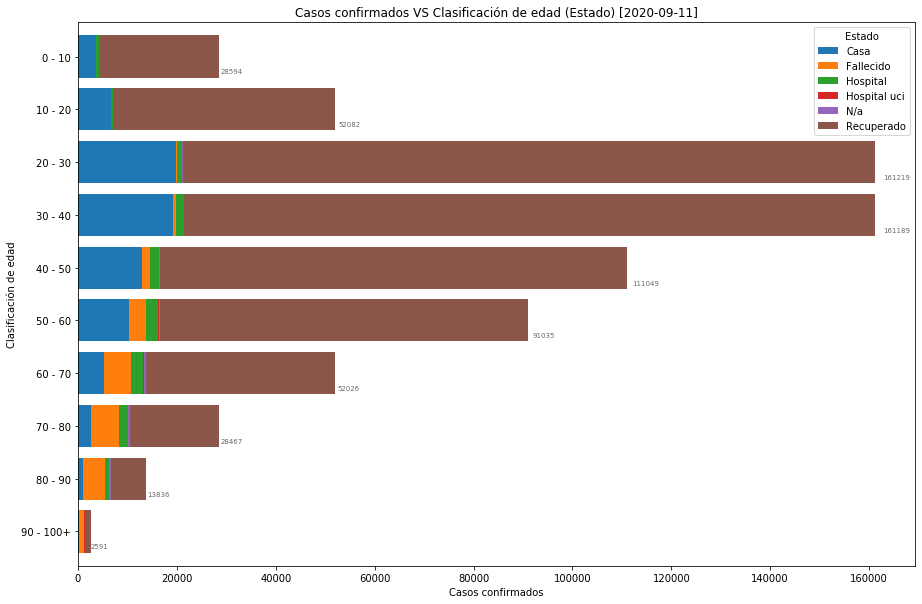

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  3640         35       581            15   34   
10 - 20                 6743         36       304             8   27   
20 - 30                19816        284       974            37   61   
30 - 40                19194        724      1449            83   57   
40 - 50                13001       1620      1684           112  107   
50 - 60                10331       3359      2476           197  174   
60 - 70                 5310       5419      2411           226  316   
70 - 80                 2552       5766      1713           177  347   
80 - 90                 1088       4304       856            65  286   
90 - 100+                242        971       109             4   69   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      24289  
10 - 20                     44964  
20 - 30                    140047  
30 - 40                    139682  
40 - 50                     94525  
50 - 60                     74498  
60 - 70                     38344  
70 - 80                     17912  
80 - 90                      7237  
90 - 100+                    1196

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

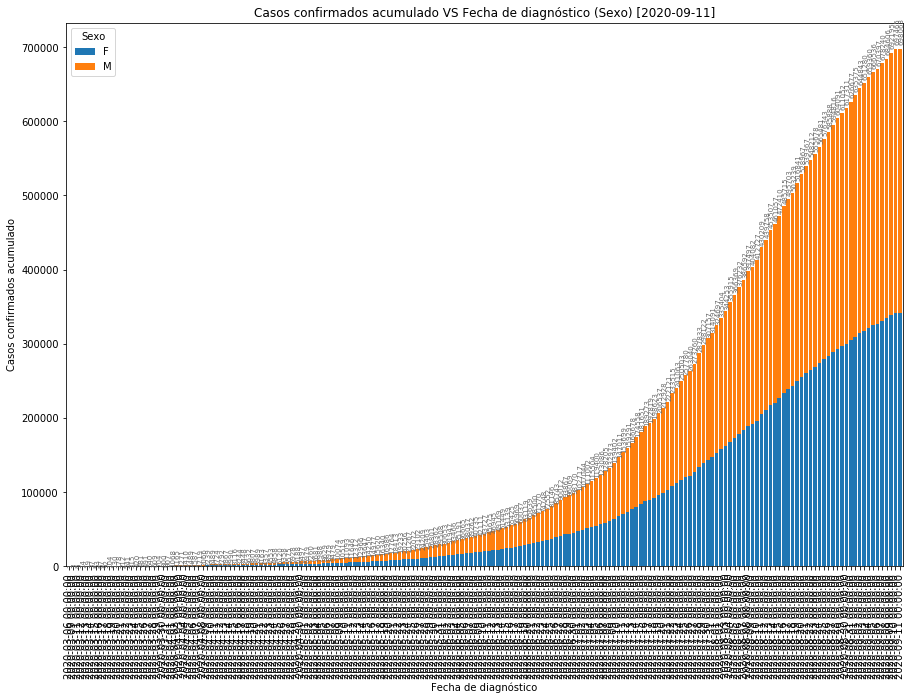

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-11            341347.0  356716.0
2020-09-10            341043.0  356422.0
2020-09-09            338284.0  353911.0
2020-09-08            334422.0  350184.0
2020-09-07            331152.0  347088.0
2020-09-06            327079.0  343318.0
2020-09-05            325104.0  341432.0
2020-09-04            321707.0  337653.0
2020-09-03            317359.0  333921.0
2020-09-02            314075.0  330768.0
2020-09-01            309241.0  326134.0
2020-08-31            304876.0  321801.0
2020-08-30            299944.0  317367.0
2020-08-29            296772.0  314280.0
2020-08-28            293243.0  310848.0
2020-08-27            288567.0  306249.0
2020-08-26            284068.0  301820.0
2020-08-25            279201.0  297142.0
2020-08-24            273748.0  291733.0
2020-08-23            268867.0  286811.0
2020-08-22            265089.0  283123.0
2020-08-21            260919.0  278448.0
2020-08-20            255678.0  273289.0
2020-08-19            249568.0  267273.0
2020-08-18            242477.0  260762.0
2020-08-17            238837.0  256866.0
2020-08-16            233563.0  252152.0
2020-08-15            226610.0  245800.0
2020-08-14            220844.0  240213.0
2020-08-13            216976.0  236531.0
2020-08-12            210101.0  229657.0
2020-08-11            205370.0  224839.0
2020-08-10            196311.0  216416.0
2020-08-09            191974.0  212108.0
2020-08-08            188579.0  208918.0
2020-08-07            183272.0  203320.0
2020-08-06            178211.0  198021.0
2020-08-05            173329.0  193040.0
2020-08-04            168098.0  187817.0
2020-08-03            162245.0  182008.0
2020-08-02            157965.0  177439.0
2020-08-01            152492.0  172205.0
2020-07-31            147361.0  166730.0
2020-07-30            143889.0  163268.0
2020-07-29            139493.0  158629.0
2020-07-28            134396.0  153437.0
2020-07-27            127304.0  145956.0
2020-07-26            122418.0  140622.0
2020-07-25            120007.0  137773.0
2020-07-24            116334.0  134169.0
2020-07-23            111971.0  129092.0
2020-07-22            108407.0  125108.0
2020-07-21            103261.0  118860.0
2020-07-20             98958.0  113970.0
2020-07-19             95976.0  110561.0
2020-07-18             92192.0  106431.0
2020-07-17             89419.0  103400.0
2020-07-16             87672.0  101601.0
2020-07-15             83940.0   97711.0
2020-07-14             80591.0   93967.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

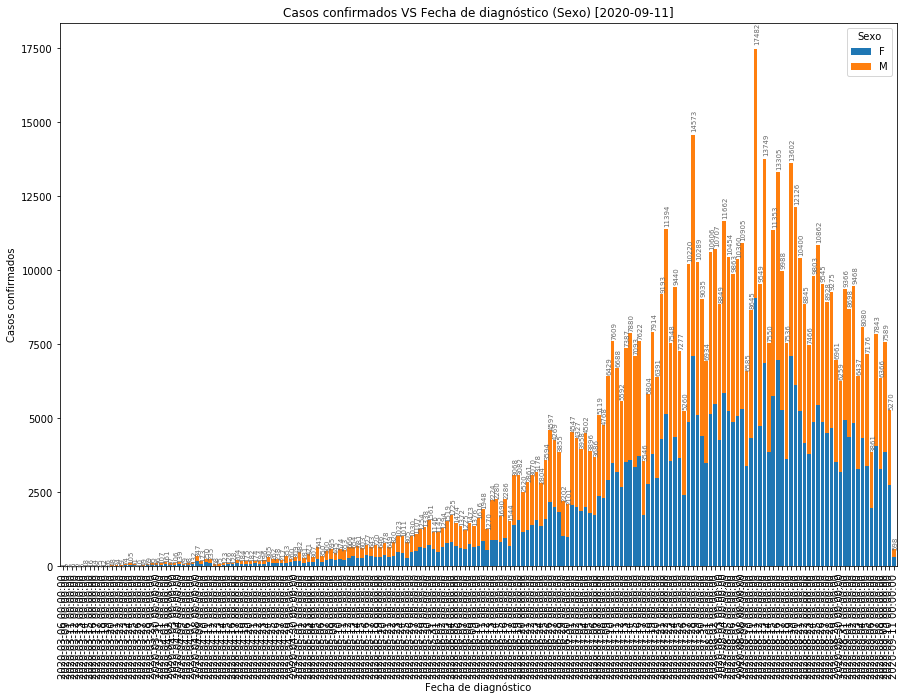

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-11             304.0   294.0
2020-09-10            2759.0  2511.0
2020-09-09            3862.0  3727.0
2020-09-08            3270.0  3096.0
2020-09-07            4073.0  3770.0
2020-09-06            1975.0  1886.0
2020-09-05            3397.0  3779.0
2020-09-04            4348.0  3732.0
2020-09-03            3284.0  3153.0
2020-09-02            4834.0  4634.0
2020-09-01            4365.0  4333.0
2020-08-31            4932.0  4434.0
2020-08-30            3172.0  3087.0
2020-08-29            3529.0  3432.0
2020-08-28            4676.0  4599.0
2020-08-27            4499.0  4429.0
2020-08-26            4867.0  4678.0
2020-08-25            5453.0  5409.0
2020-08-24            4881.0  4922.0
2020-08-23            3778.0  3688.0
2020-08-22            4170.0  4675.0
2020-08-21            5241.0  5159.0
2020-08-20            6110.0  6016.0
2020-08-19            7091.0  6511.0
2020-08-18            3640.0  3896.0
2020-08-17            5274.0  4714.0
2020-08-16            6953.0  6352.0
2020-08-15            5766.0  5587.0
2020-08-14            3868.0  3682.0
2020-08-13            6875.0  6874.0
2020-08-12            4731.0  4818.0
2020-08-11            9059.0  8423.0
2020-08-10            4337.0  4308.0
2020-08-09            3395.0  3190.0
2020-08-08            5307.0  5598.0
2020-08-07            5061.0  5299.0
2020-08-06            4882.0  4981.0
2020-08-05            5231.0  5223.0
2020-08-04            5853.0  5809.0
2020-08-03            4280.0  4569.0
2020-08-02            5473.0  5234.0
2020-08-01            5131.0  5475.0
2020-07-31            3472.0  3462.0
2020-07-30            4396.0  4639.0
2020-07-29            5097.0  5192.0
2020-07-28            7092.0  7481.0
2020-07-27            4886.0  5334.0
2020-07-26            2411.0  2849.0
2020-07-25            3673.0  3604.0
2020-07-24            4363.0  5077.0
2020-07-23            3564.0  3984.0
2020-07-22            5146.0  6248.0
2020-07-21            4303.0  4890.0
2020-07-20            2982.0  3409.0
2020-07-19            3784.0  4130.0
2020-07-18            2773.0  3031.0
2020-07-17            1747.0  1799.0
2020-07-16            3732.0  3890.0
2020-07-15            3349.0  3744.0
2020-07-14            3586.0  4294.0

### - Casos confirmados VS Clasificación de edad (Sexo)

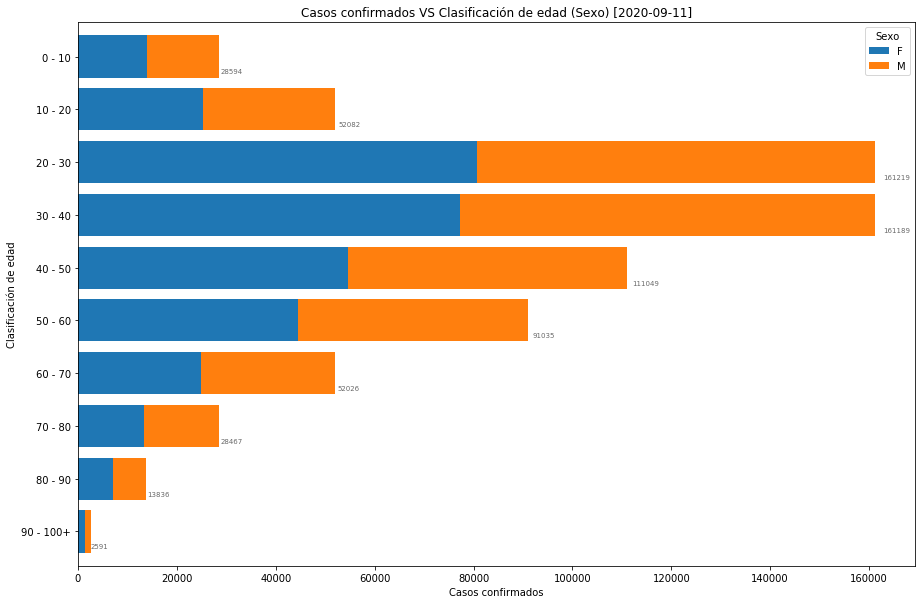

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 13927  14667
10 - 20                25241  26841
20 - 30                80793  80426
30 - 40                77347  83842
40 - 50                54692  56357
50 - 60                44419  46616
60 - 70                24967  27059
70 - 80                13326  15141
80 - 90                 7088   6748
90 - 100+               1468   1123

### - Casos confirmados VS Estado (Sexo)

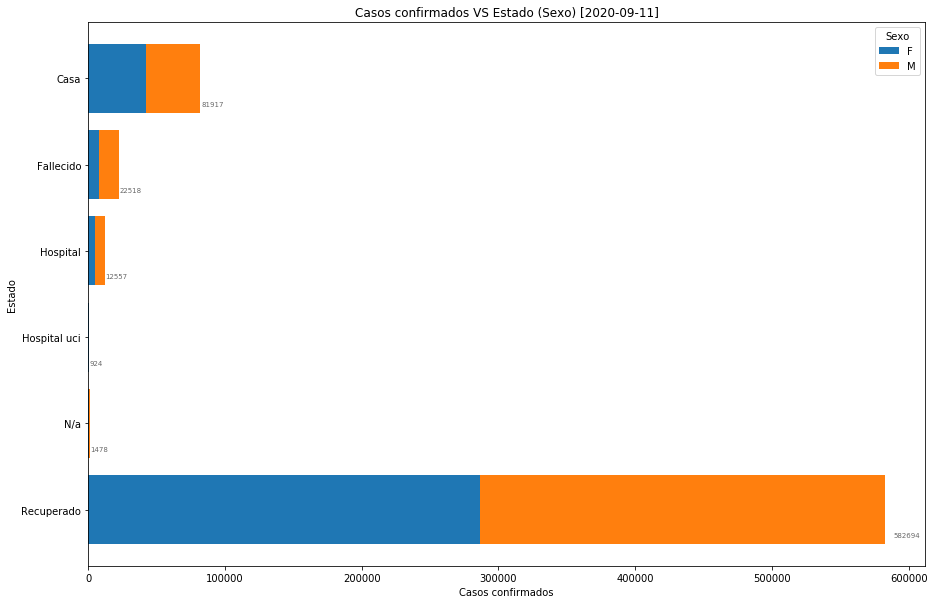

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           42304   39613
Fallecido       8066   14452
Hospital        5325    7232
Hospital uci     336     588
N/a              642     836
Recuperado    286595  296099

### - Casos confirmados VS Tipo de contagio (Sexo)

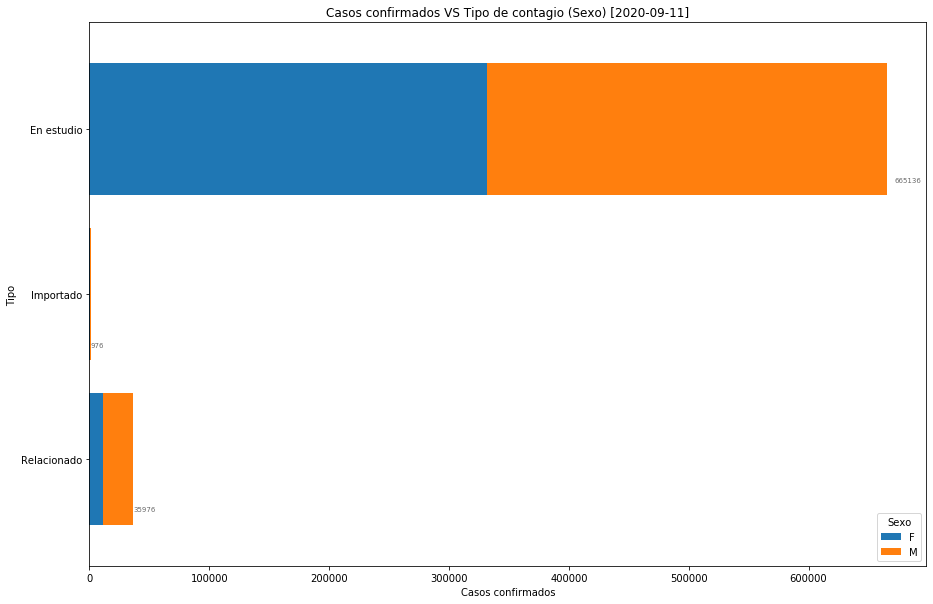

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   331721  333415
Importado       462     514
Relacionado   11085   24891

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

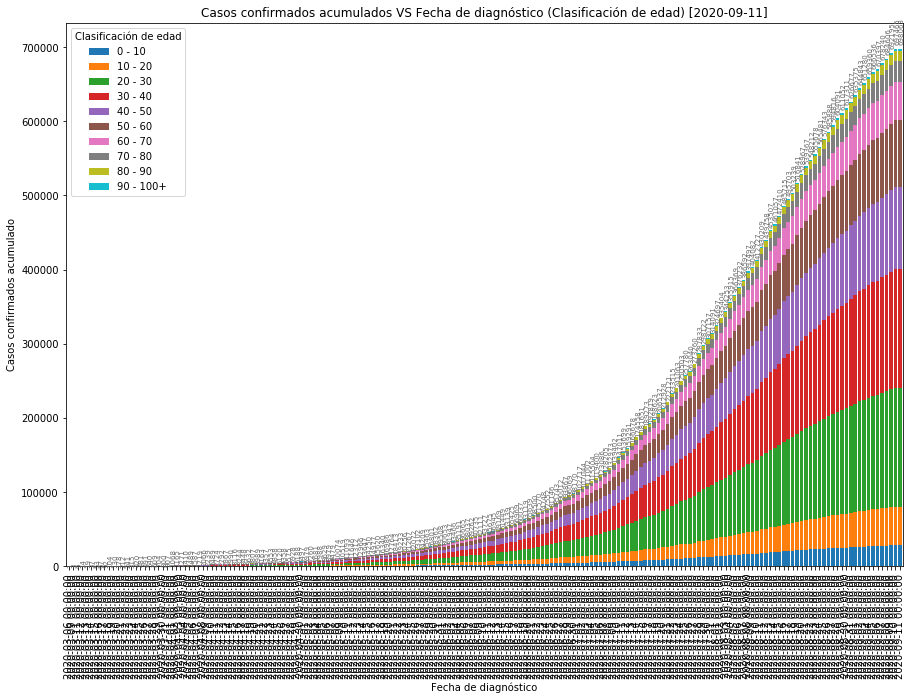

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-11              28454    51793   160240   160218   110456    90546   
2020-09-10              28432    51755   160108   160100   110364    90462   
2020-09-09              28240    51367   158961   158895   109551    89746   
2020-09-08              27965    50817   157199   157086   108343    88737   
2020-09-07              27728    50342   155824   155652   107366    87920   
2020-09-06              27422    49752   154071   153926   106101    86891   
2020-09-05              27285    49476   153220   153039   105490    86408   
2020-09-04              27012    48834   151563   151403   104382    85522   
2020-09-03              26688    48315   149674   149565   103109    84445   
2020-09-02              26455    47834   148158   148110   102072    83588   
2020-09-01              26075    47187   146042   146005   100600    82339   
2020-08-31              25733    46507   144031   144024    99252    81201   
2020-08-30              25314    45794   141788   141934    97770    80048   
2020-08-29              25069    45324   140310   140520    96786    79248   
2020-08-28              24815    44798   138682   138993    95705    78295   
2020-08-27              24488    44169   136600   136819    94247    77049   
2020-08-26              24135    43526   134518   134768    92821    75907   
2020-08-25              23784    42811   132457   132597    91276    74713   
2020-08-24              23388    42103   129994   130041    89521    73265   
2020-08-23              23023    41383   127718   127827    87983    71999   
2020-08-22              22712    40778   125940   126088    86879    71015   
2020-08-21              22389    40116   123902   123984    85547    69895   
2020-08-20              21964    39365   121430   121618    83902    68530   
2020-08-19              21477    38505   118766   118895    81978    66911   
2020-08-18              20845    37508   115716   115859    79741    65182   
2020-08-17              20590    36993   114038   114159    78539    64151   
2020-08-16              20076    36231   111824   112058    76945    62813   
2020-08-15              19458    35094   108865   109160    74828    61062   
2020-08-14              18958    34254   106253   106651    73039    59535   
2020-08-13              18704    33710   104522   104972    71824    58471   
2020-08-12              18080    32643   101411   101863    69626    56659   
2020-08-11              17732    32005    99321    99653    68111    55390   
2020-08-10              16927    30741    95195    95612    65274    53143   
2020-08-09              16596    30059    93243    93605    63920    52028   
2020-08-08              16350    29629    91727    92171    62834    51140   
2020-08-07              15929    28840    89272    89512    61116    49710   
2020-08-06              15511    28068    86911    87072    59467    48364   
2020-08-05              15062    27320    84719    84818    57883    47081   
2020-08-04              14633    26591    82320    82394    56190    45709   
2020-08-03              14141    25767    79645    79667    54269    44125   
2020-08-02              13817    25156    77640    77612    52918    42902   
2020-08-01              13374    24435    75228    75217    51109    41398   
2020-07-31              12960    23578    72669    72701    49487    40048   
2020-07-30              12682    23113    71133    71055    48308    39189   
2020-07-29              12338    22396    68943    68915    46972    38005   
2020-07-28              11954    21643    66506    66427    45274    36759   
2020-07-27              11325    20511    63190    63142    42958    34832   
2020-07-26              10940    19790    60787    60748    41277    33613   
2020-07-25              10729    19465    59596    59514    40458    32924   
2020-07-24            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

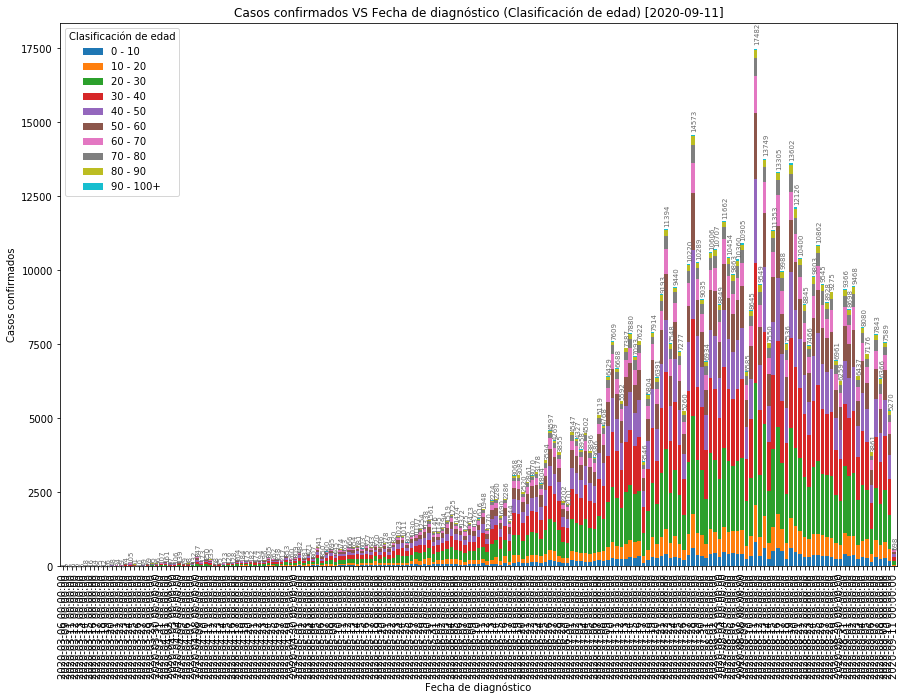

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-11                 22       38      132      118       92       84   
2020-09-10                192      388     1147     1205      813      716   
2020-09-09                275      550     1762     1809     1208     1009   
2020-09-08                237      475     1375     1434      977      817   
2020-09-07                306      590     1753     1726     1265     1029   
2020-09-06                137      276      851      887      611      483   
2020-09-05                273      642     1657     1636     1108      886   
2020-09-04                324      519     1889     1838     1273     1077   
2020-09-03                233      481     1516     1455     1037      857   
2020-09-02                380      647     2116     2105     1472     1249   
2020-09-01                342      680     2011     1981     1348     1138   
2020-08-31                419      713     2243     2090     1482     1153   
2020-08-30                245      470     1478     1414      984      800   
2020-08-29                254      526     1628     1527     1081      953   
2020-08-28                327      629     2082     2174     1458     1246   
2020-08-27                353      643     2082     2051     1426     1142   
2020-08-26                351      715     2061     2171     1545     1194   
2020-08-25                396      708     2463     2556     1755     1448   
2020-08-24                365      720     2276     2214     1538     1266   
2020-08-23                311      605     1778     1739     1104      984   
2020-08-22                323      662     2038     2104     1332     1120   
2020-08-21                425      751     2472     2366     1645     1365   
2020-08-20                487      860     2664     2723     1924     1619   
2020-08-19                632      997     3050     3036     2237     1729   
2020-08-18                255      515     1678     1700     1202     1031   
2020-08-17                514      762     2214     2101     1594     1338   
2020-08-16                618     1137     2959     2898     2117     1751   
2020-08-15                500      840     2612     2509     1789     1527   
2020-08-14                254      544     1731     1679     1215     1064   
2020-08-13                624     1067     3111     3109     2198     1812   
2020-08-12                348      638     2090     2210     1515     1269   
2020-08-11                805     1264     4126     4041     2837     2247   
2020-08-10                331      682     1952     2007     1354     1115   
2020-08-09                246      430     1516     1434     1086      888   
2020-08-08                421      789     2455     2659     1718     1430   
2020-08-07                418      772     2361     2440     1649     1346   
2020-08-06                449      748     2192     2254     1584     1283   
2020-08-05                429      729     2399     2424     1693     1372   
2020-08-04                492      824     2675     2727     1921     1584   
2020-08-03                324      611     2005     2055     1351     1223   
2020-08-02                443      721     2412     2395     1809     1504   
2020-08-01                414      857     2559     2516     1622     1350   
2020-07-31                278      465     1536     1646     1179      859   
2020-07-30                344      717     2190     2140     1336     1184   
2020-07-29                384      753     2437     2488     1698     1246   
2020-07-28                629     1132     3316     3285     2316     1927   
2020-07-27                385      721     2403     2394     1681     1219   
2020-07-26                211      325     1191     1234      819      689   
2020-07-25                283      481     1641     1706     1163      989   
2020-07-24            

### - Casos confirmados VS Estado (Clasificación de edad)

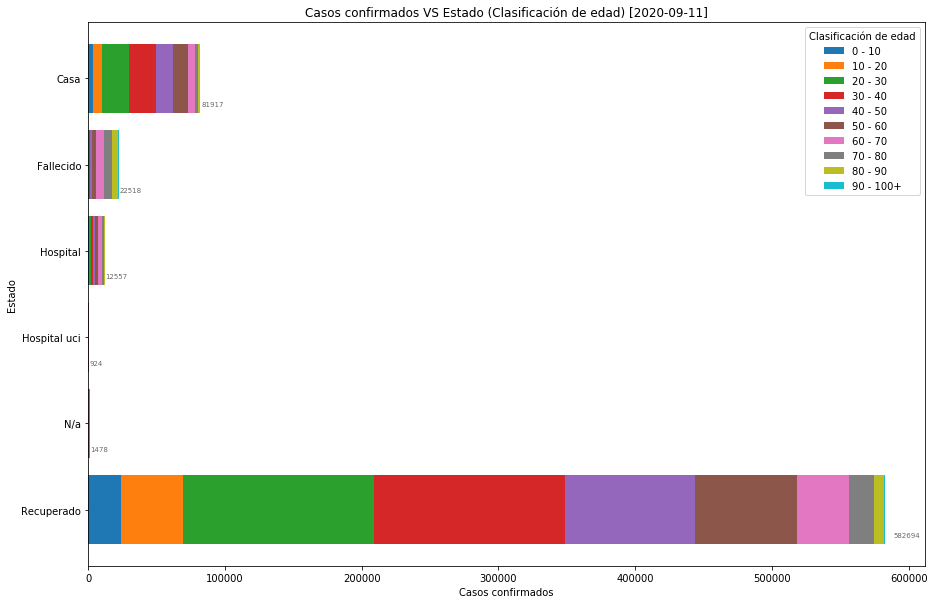

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     3640     6743    19816    19194    13001    10331   
Fallecido                  35       36      284      724     1620     3359   
Hospital                  581      304      974     1449     1684     2476   
Hospital uci               15        8       37       83      112      197   
N/a                        34       27       61       57      107      174   
Recuperado              24289    44964   140047   139682    94525    74498   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      5310     2552     1088        242  
Fallecido                 5419     5766     4304        971  
Hospital                  2411     1713      856        109  
Hospital uci               226      177       65          4  
N/a                        316      347      286         69  
Recuperado               38344    17912     7237       1196

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

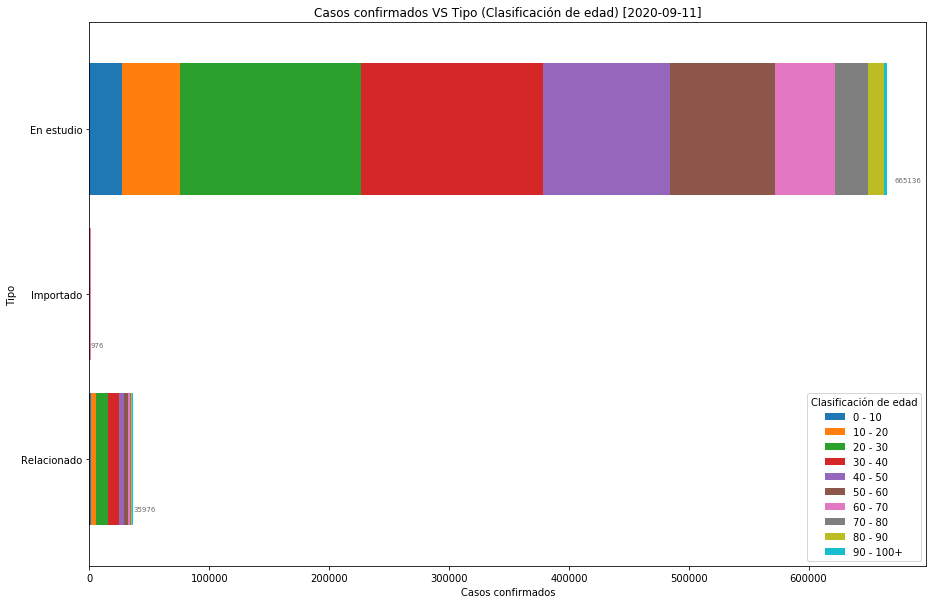

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              27441    47879   151052   151710   106271    87670   
Importado                   7       37      241      224      173      147   
Relacionado              1146     4166     9926     9255     4605     3218   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               50184    27472    13091       2366  
Importado                   99       37       10          1  
Relacionado               1743      958      735        224

## Y para los curiosos... 👀

### - Casos activos VS Ciudad de ubicación (Estado) [TOP 50]

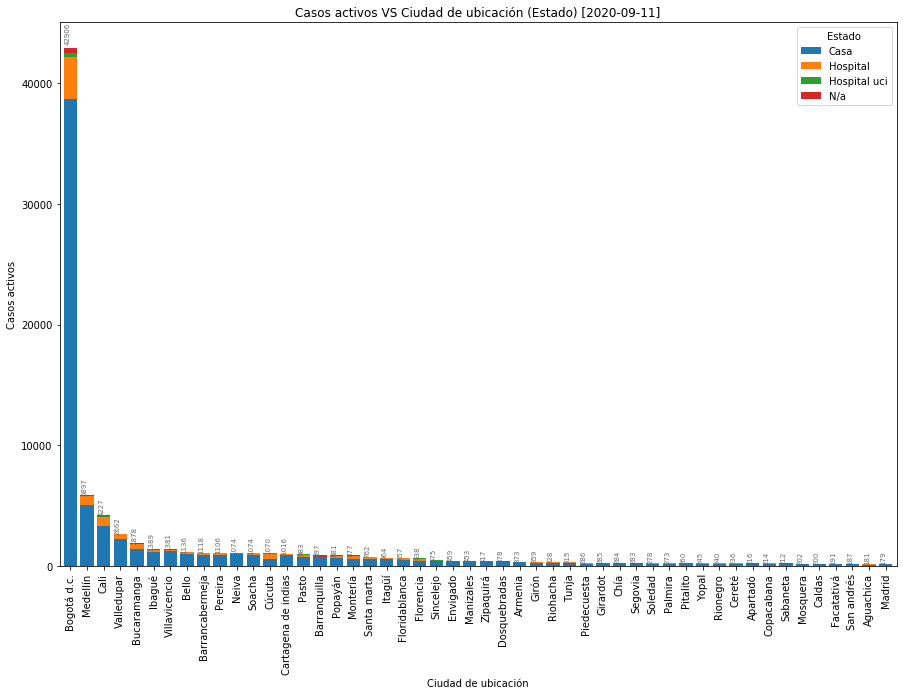

In [46]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [47]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          38667.0    3542.0         308.0  389.0  42906.0
Medellín              5075.0     699.0          52.0   71.0   5897.0
Cali                  3280.0     807.0          42.0   98.0   4227.0
Valledupar            2226.0     403.0          20.0   13.0   2662.0
Bucaramanga           1418.0     412.0          30.0   18.0   1878.0
Ibagué                1195.0     160.0          12.0   22.0   1389.0
Villavicencio         1227.0     135.0           6.0   13.0   1381.0
Bello                 1039.0      84.0           8.0    5.0   1136.0
Barrancabermeja        946.0     159.0           7.0    6.0   1118.0
Pereira                940.0     143.0          13.0   10.0   1106.0
Neiva                  992.0      43.0          32.0    7.0   1074.0
Soacha                 912.0     144.0           9.0    9.0   1074.0
Cúcuta                 611.0     384.0          63.0   12.0   1070.0
Cartagena de indias    926.0      52.0           1.0   37.0   1016.0
Pasto                  752.0     202.0          13.0   16.0    983.0
Barranquilla           765.0      19.0           1.0  112.0    897.0
Popayán                678.0     186.0           6.0   11.0    881.0
Montería               567.0     252.0           8.0   50.0    877.0
Santa marta            558.0     177.0           9.0   18.0    762.0
Itagüí                 602.0      53.0           3.0    6.0    664.0
Floridablanca          461.0     178.0          13.0    5.0    657.0
Florencia              413.0     207.0           6.0   12.0    638.0
Sincelejo              383.0      70.0           7.0   15.0    475.0
Envigado               420.0      35.0           2.0    2.0    459.0
Manizales              405.0      36.0           2.0   10.0    453.0
Zipaquirá              390.0      22.0           1.0    4.0    417.0
Dosquebradas           321.0      53.0           3.0    1.0    378.0
Armenia                333.0      39.0           0.0    1.0    373.0
Girón                  264.0      91.0           1.0    3.0    359.0
Riohacha               241.0      78.0           3.0    6.0    328.0
Tunja                  275.0      30.0           4.0    6.0    315.0
Piedecuesta            203.0      75.0           8.0    0.0    286.0
Girardot               238.0      46.0           1.0    0.0    285.0
Chía                   245.0      33.0           2.0    4.0    284.0
Segovia                274.0       8.0           1.0    0.0    283.0
Soledad                191.0      40.0           3.0   44.0    278.0
Palmira                169.0      95.0           2.0    7.0    273.0
Pitalito               227.0      24.0           6.0    3.0    260.0
Yopal                  200.0      43.0           2.0    0.0    245.0
Rionegro               199.0      35.0           3.0    3.0    240.0
Cereté                 192.0      36.0           0.0    8.0    236.0
Apartadó               163.0      46.0           2.0    5.0    216.0
Copacabana             204.0       8.0           0.0    2.0    214.0
Sabaneta               201.0      10.0           0.0    1.0    212.0
Mosquera               176.0      20.0           4.0    2.0    202.0
Caldas                 185.0      15.0           0.0    0.0    200.0
Facatativá             162.0      24.0           4.0    1.0    191.0
San andrés             168.0      18.0           0.0    1.0    187.0
Aguachica               85.0      88.0           7.0    1.0    181.0
Madrid                 156.0      18.0           4.0    1.0    179.0

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)